# **Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Grupo ( A )

---


Aluna(o): Luana Guedes Barros Martins

---

Aluna(o): Ruan Chaves Rodrigues

---

Aluna(o): Thiago Monteles de Souza

---

# Atividade Prática 06 - Processamento de Linguagem Natural

Particionamento das atividades:
- Luana Guedes Barros Martins: Desenvolvedor
- Ruan Chaves Rodrigues: Analista de dados
- Thiago Monteles de Souza: Gerente do Projeto

## Preparação do Ambiente Virtual

In [1]:
!pip install spacy

In [2]:
!python -m spacy download pt_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [3]:
!pip install gensim

In [4]:
!pip install nltk

In [5]:
# Imports

from collections import defaultdict
import numpy as np
from collections import Counter

import pandas as pd

import nltk
import spacy 
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import seaborn as sns

## Descrição do Problema

Utilizando técnicas de Processamento de Linguagem Natural (PLN), será desenvolvido uma ferramenta que permita a comparação de pequenos textos. Devem ser definidas métricas de comparação que classifique os textos segundo critérios de similaridade.

A ferramenta deverá ser aplicada aos Estudos Dirigidos desenvolvidos ao longo do curso de Inteligência Artificial 2019-3. Para cada estudo, deve-se construir uma matriz que mostre a similaridade entre os documentos. Depois, definir um documento de referência e traçar um gráfico de similaridade dos demais em relação a ele.

## Tratamento dos Dados

Dado os arquivos disponibilizados no formato CSV(Comma Separated Values), iremos construir um *corpus*, um conjunto de documentos que servirá como base para análise.

In [6]:
"""
# Carregar os datasets "Dados - ED05.csv", "Dados - ED08.csv" e 
# "Dados - ED09.csv"para o ambiente virtual.

from google.colab import files
uploaded = files.upload()
"""

'\n# Carregar os datasets "Dados - ED05.csv", "Dados - ED08.csv" e \n# "Dados - ED09.csv"para o ambiente virtual.\n\nfrom google.colab import files\nuploaded = files.upload()\n'

Para extrair as principais características, uma série de prepações nos dados crus devem ser realizadas:

- Geração de tokens: consiste na quebra das sentenças em partes menores para facilitar a análise. Cada token irá corresponder a uma palavra do texto de análise. Para esse processo será utilizado a biblioteca [SpaCy](https://spacy.io/), que é uma biblioteca de PLN que possui algumas funcionalidades básicas como a geração de tokens.
- StopWords: *Stop words* são palavras muito comuns em um idioma, como: o, de, uma. Sua remoção ajuda a melhorar a entrada para o modelo. Para isso iremos carregar uma lista de stop words utilizando o pacote Python [NLTK](https://www.nltk.org/).
- Lematização: Para resolver o problema de análise de diversos tempos verbais diferentes, analisaremos não o verbo no tempo verbal que ele foi escrito, mas ele em sua raiz. O método do Spacy que realiza esse procedimento é o método .lemma_.


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/luana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def preprocess(dataframe):
    
    # Carrega lista de stop words em português.
    stopwords = nltk.corpus.stopwords.words('portuguese')
    
    # Carrega um modelo de PLN em português do spacy.
    nlp = spacy.load("pt_core_news_sm")
    
    # Carrega o arquivo csv
    docs = pd.read_csv(source, sep=";").fillna('o').astype(str).values.flatten().tolist()
    
    # Cria-se uma lista do tipo (aluno-resposta) do documento.
    ids = pd.read_csv(source, sep=";").fillna('o').values
    ids = [ [(idx2, idx) for idx,v in enumerate(v2) ] for idx2,v2 in enumerate(ids) ]
    ids = [x for y in ids for x in y ]
    
    # Retira do documento todas as stopwords e pontuações.
    docs = [nlp(x) for x in docs]
    docs = [ [ y for y in x if y.is_punct == False and y.text.lower() not in stopwords] for x in docs ]
    
    # Processo de lematização. 
    tokens = [ [ y.lemma_ for y in x ] for x in docs ]
    
    # Quantidade de cada token no documento.
    counter = dict(Counter([ x for y in tokens for x in y ]))
    
    # Retira os tokens com baixo número de ocorrência.
    low_freq = [x for x in counter.keys() if counter[x] == 1]
    tokens = [ [ x for x in y if x not in low_freq ] for y in tokens ]
    
    #
    token_docs = [ ' '.join(x) for x in tokens ]
    
    # Encapsula o mapeamento entre palavras normalizadas e seus ids.
    mydict = corpora.Dictionary([simple_preprocess(line) for line in token_docs])
    
    # Converte o documento para o formato bag-of-words(1)
    # lista de tuplas do tipo (token_id, token_count)
    corpus = [mydict.doc2bow(simple_preprocess(line)) for line in token_docs]
    
    return {
        "nlp": docs,
        "corpus" : corpus,
        "dict": mydict,
        "tokens": tokens,
        "ids" : ids
    }

$^1$: Documentos no gensim são representados por vetores sparsos chamados de *bag-of-words vectors*.

## Definição do Modelo

Para construir a matriz de similaridade entre os documentos deste trabalho, iremos calcular o valor **TF-IDF** (abreviação do inglês *Term Frenquency - Inverse Document Frequency*, que significa frequência do termo–inverso da frequência nos documentos). 

O TF_IDF é uma medida estatística que indica a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um *corpus*. 

Para calcular o valor TF_IDF multiplica-se a frequência de um termo (TF) pela frequência inversa do documento (IDF). 
- O termo TF mede a frequência de ocorrência de um termo em um documento. Como cada documento é diferente em tamanho, é possível que um termo apareça muito mais vezes em documentos longos do que em documentos mais curtos. Assim, o termo freqüência é freqüentemente dividido pelo tamanho do documento (também conhecido como número total de termos no documento) como forma de normalização.
- O termo IDF mede a importância de um termo. Enquanto computa TF, todos os termos são considerados igualmente importantes. No entanto, certos termos, como "é", "de" e "aquilo", podem aparecer muitas vezes, mas têm pouca importância. 

Assim, temos que:

$$tfidf(i, j, D) = tf(i, j) \cdot idf(i, D)$$

ou

$$tfidf_{i, j} = frequência_{i, j} * log_2\frac{D}{frequênciaDocumento_i}$$

Sendo que:
- $i$ = termo
- $j$ = documento
- $D$ = Número total de documentos


O TF_IDF é calculado com a API [gensim](https://radimrehurek.com/gensim/index.html), utilizando o [models.TfidfModel](https://radimrehurek.com/gensim/models/tfidfmodel.html), onde seus principais métodos são:
- Construtor: calcula que calcula contagens de documentos inversas para todos os termos do corpus de treinamento.
- Método [ ]: transforma uma simples representação de contagem no espaço TfIdf.


Como parâmetro obrigatório, *models.TfidfModel* recebe um *corpus*.


Após calcular o valor TF_IDF será então gerado a matriz de similaridade utilizando-se do [similarities.SparseMatrixSimilarity](https://radimrehurek.com/gensim/similarities/docsim.html#gensim.similarities.docsim.SparseMatrixSimilarity), que dado uma lista de documentos no formato *bag-of-words vector*$^1$ calcula a semelhança de cosseno em um corpo de documentos armazenando a matriz de índice na memória.

In [9]:
def tfidf(preprocess_dict):
    
    # Pega o corpus do conjunto de dados já processados
    corpus = preprocess_dict['corpus']
    
    # Frequência do documento: quantos documentos possuem tais tokens
    mydict = preprocess_dict['dict']
    nf = len(mydict.dfs)
    
    # Transformação entre co-ocorrência de documento-palavra
    tfidf = models.TfidfModel(corpus)
    
    # Matriz de similaridade 
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=nf)
    
    return {
        "model" : tfidf,
        "index" : index
    }

## Resultados

Abaixo iremos, para cada documento .csv, comparar o grau de similaridade entre as respostas de cada aluno. Assim conseguiremos traçar quais alunos tiveram respostas parecidas (plágio) com outros alunos.

Para a visualização dos resultados, será utilizado um gráfico de heatmap, onde cada linha e cada colunha representa um aluno, e cada célula do gráfico representa o grau de similaridade entre as respostas de um par de aluno. Após a visualização gráfica, será msotrado quais foram as respostas que obtiveram o maior grau de similaridade do documento analisado.

In [10]:
def get_dataplot(preprocess_dict, model_dict):
    corpus = preprocess_dict['corpus']
    tfidf = model_dict['model']
    index = model_dict['index']
    dataplot = []
    for item in corpus:
        dataplot.append(index[tfidf[item]])
    return pd.DataFrame(dataplot)

def get_dict(preprocess_dict=None, dataplot=None, threshold=None):
    ids = preprocess_dict['ids']
    df = dataplot
    tmp = df.applymap(lambda x: 'nan' if x < threshold else x)
    arr = tmp.values.tolist()
    matches = []
    
    for idx, item in enumerate(arr):
        for idx2, item2 in enumerate(item):
            if idx != idx2 and arr[idx][idx2] != 'nan':
                matches.append([idx, idx2])
    pairs = [ [ ids[x][0] for x in y ] for y in matches ]
    
    dict_pairs = dict(Counter([ tuple(x) for x in pairs ])).items()
    
    max_val = max([ x[0][0] for x in dict_pairs ])
    dataplot = []
    for i in range(max_val):
        row = []
        for j in range(max_val):
            if i != j:
                for item in dict_pairs:
                    if i == item[0][0] and j == item[0][1]:
                        row.append(item[1])
                        break
                else:
                    row.append(0)
        dataplot.append(row)
    return dataplot

In [11]:
plt.rcParams["figure.figsize"] = (20,10)

### Primeiro Documento

In [12]:
source = "Dados - ED05.csv"
data_dict = preprocess(source)
model_dict = tfidf(data_dict)

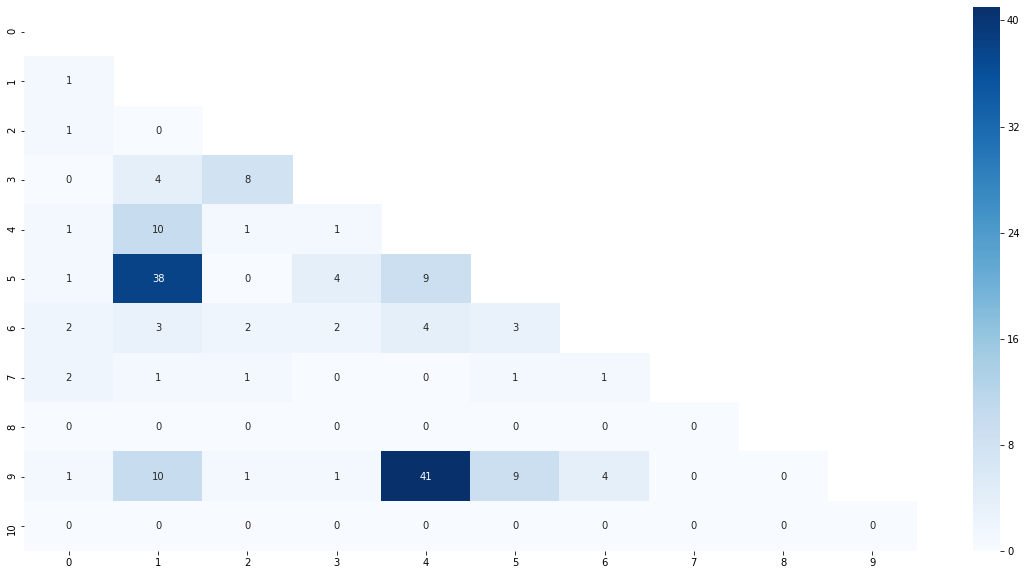

In [13]:
dataplot = get_dict(preprocess_dict=data_dict, 
                    dataplot=get_dataplot(data_dict, model_dict), 
                    threshold=0.9)

mask = np.zeros_like(dataplot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=pd.DataFrame(dataplot), mask=mask, cmap='Blues', annot=True)

In [14]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv(source, sep=";").iloc[[9,4]].transpose().sample(5)

,9,4
Resposta 22,"A principal limitação das redes de uma camada, como as redes perceptron e adaline, é que elas conseguem classificar apenas objetos que são linearmente separáveis.","A principal limitação das redes de uma camada, como as redes perceptron e adaline, é que elas conseguem classificar apenas objetos que são linearmente separáveis."
Resposta 21,"As redes adeline são comumente aplicadas em problemas supervisionados de regressão. Em problemas de classificação, as saídas dos neurônios devem, ser discretizadas. As redes perceptron, por outro lado, foram propostas para a solução de problemas de classificação.","As redes adeline são comumente aplicadas em problemas supervisionados de regressão. Em problemas de classificação, as saídas dos neurônios devem, ser discretizadas. As redes perceptron, por outro lado, foram propostas para a solução de problemas de classificação."
Resposta 4,O contato entre a terminação de um axônio e o dendrito de outro neurônio é denominado sinapse. As sinapses são as unidades que medeiam as interações entre os neurônios e podem ser excitatórias ou inibitórias.,O contato entre a terminação de um axônio e o dendrito de outro neurônio é denominado sinapse. As sinapses são as unidades que medeiam as interações entre os neurônios e podem ser excitatórias ou inibitórias.
Resposta 31,"O algoritmo back-propagation é baseado na regra delta utilizada na rede adaline, e também é conhecido como regra delta generalizada. Ele é constituído da iteração de duas fases, uma forward e outra backward. Na fase forward, cada objeto de entrada é apresentado À rede Já na fase backward o valor do erro de cada neurônio da camada de saída é utilizado para ajustar seus pesos de entrada. O ajuste prossegue da camada de saída até a primeira camada intermediária","O algoritmo back-propagation é baseado na regra delta utilizada na rede adaline, e também é conhecido como regra delta generalizada. Ele é constituído da iteração de duas fases, uma forward e outra backward. Na fase forward, cada objeto de entrada é apresentado À rede Já na fase backward o valor do erro de cada neurônio da camada de saída é utilizado para ajustar seus pesos de entrada. O ajuste prossegue da camada de saída até a primeira camada intermediária."
Resposta 12,"Além do grau de conectividade, as RNAs podem apresentar ou não conexões de retroalimentação, ou feedback. As conexões de retroalimentação permitem que um neurônio receba em seus terminais de entrada e saída de um neurônio da mesma camada ou de uma camada posterior. O neurônio pode inclusive receber sua própria saída em um de seus terminais de entrada. As redes que contém este tipo de conexão são denominadas redes com retropropagação, conhecidas como redes recorrentes.","Além do grau de conectividade, as RNAs podem apresentar ou não conexões de retroalimentação, ou feedback. As conexões de retroalimentação permitem que um neurônio receba em seus terminais de entrada e saída de um neurônio da mesma camada ou de uma camada posterior. O neurônio pode inclusive receber sua própria saída em um de seus terminais de entrada. As redes que contém este tipo de conexão são denominadas redes com retropropagação, conhecidas como redes recorrentes."


### Segundo Documento

In [15]:
source = "Dados - ED08.csv"
data_dict = preprocess(source)
model_dict = tfidf(data_dict)

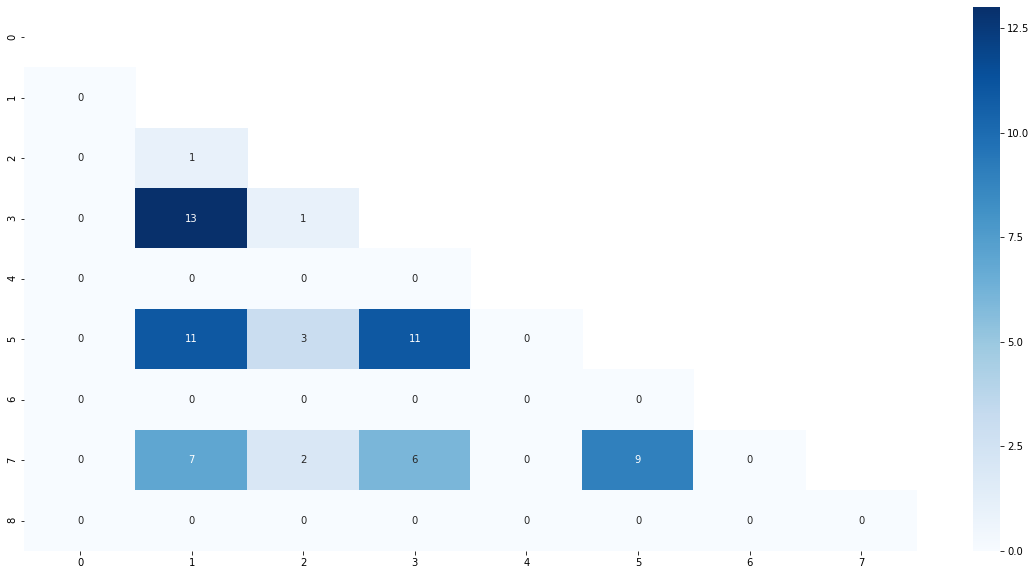

In [16]:
dataplot = get_dict(preprocess_dict=data_dict, 
                    dataplot=get_dataplot(data_dict, model_dict), 
                    threshold=0.9)

mask = np.zeros_like(dataplot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=pd.DataFrame(dataplot), mask=mask, cmap='Blues', annot=True)

In [17]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv(source, sep=";").iloc[[3,1]].transpose().sample(5)

,3,1
Resposta 14,"OS ALGORITMOS GENÉTICOS FUNCIONAM BEM QUANDO UM PEQUENO GRUPO DE GENES QUE ESTÃO PRÓXIMOS REPRESENTAM UMA CARACTERÍSTICA QUE CONTRIBUI PARA A ADEQUAÇÃO DE UM CROMOSSOMO. PORTANTO, A REPRESENTAÇÃO ESCOLHIDA PARA ALGORITMOS GENÉTICOS É MUITO IMPORTANTE. A SELEÇÃO ALEATÓRIA DE BITS PARA REPRESENTAR RECURSOS ESPECÍFICOS DE UMA SOLUÇÃO NÃO É SUFICIENTE. OS BITS DEVEM SER ESCOLHIDOS DE FORMA A SE AGRUPAREM NATURALMENTE EM BLOCOS DE CONSTRUÇÃO, QUE OS ALGORITMOS GENÉTICOS SÃO PROJETADOS PARA MANIPULAR.","OS ALGORITMOS GENÉTICOS FUNCIONAM BEM QUANDO UM PEQUENO GRUPO DE GENES QUE ESTÃO PRÓXIMOS REPRESENTAM UMA CARACTERÍSTICA QUE CONTRIBUI PARA A ADEQUAÇÃO DE UM CROMOSSOMO. PORTANTO, A REPRESENTAÇÃO ESCOLHIDA PARA ALGORITMOS GENÉTICOS É MUITO IMPORTANTE. A SELEÇÃO ALEATÓRIA DE BITS PARA REPRESENTAR RECURSOS ESPECÍFICOS DE UMA SOLUÇÃO NÃO É SUFICIENTE. OS BITS DEVEM SER ESCOLHIDOS DE FORMA A SE AGRUPAREM NATURALMENTE EM BLOCOS DE CONSTRUÇÃO, QUE OS ALGORITMOS GENÉTICOS SÃO PROJETADOS PARA MANIPULAR."
Resposta 11,"TANTO A MUTAÇÃO COMO O CROSSOVER PODEM DESTRUIR A PRESENÇA DE UM ESQUEMA. EM OUTRAS PALAVRAS, MUTAÇÃO E CROSSOVER SÃO CAPAZES DE REDUZIR O NÚMERO DE OCORRÊNCIAS DE UM ESQUEMA PARTICULAR EM UMA POPULAÇÃO DE CROMOSSOMOS. ELES TAMBÉM SÃO CAPAZES DE AUMENTAR O NÚMERO DE OCORRÊNCIAS DE UM DADO ESQUEMA.","TANTO A MUTAÇÃO COMO O CROSSOVER PODEM DESTRUIR A PRESENÇA DE UM ESQUEMA. EM OUTRAS PALAVRAS, MUTAÇÃO E CROSSOVER SÃO CAPAZES DE REDUZIR O NÚMERO DE OCORRÊNCIAS DE UM ESQUEMA PARTICULAR EM UMA POPULAÇÃO DE CROMOSSOMOS. ELES TAMBÉM SÃO CAPAZES DE AUMENTAR O NÚMERO DE OCORRÊNCIAS DE UM DADO ESQUEMA."
Resposta 5,"O crossover é o cruzamento entre cromossomos de uma mesma geração. O operador de crossover é aplicado a dois cromossomos com o mesmo comprimento da seguinte forma:\n\n1. Selecione um ponto de cruzamento aleatório.\n\n2. Quebre cada cromossomo em duas partes, dividindo-o no ponto de cruzamento.3. Recombine os cromossomos quebrados combinando o início de um com o final do outro, e vice-versa, para produzir dois novos cromossomos.","O crossover é o cruzamento entre cromossomos de uma mesma geração. O operador de crossover é aplicado a dois cromossomos com o mesmo comprimento da seguinte forma:\n\n1. Selecione um ponto de cruzamento aleatório.\n\n2. Quebre cada cromossomo em duas partes, dividindo-o no ponto de cruzamento.\n\n3. Recombine os cromossomos quebrados combinando a frente de um com as costas do outro, e vice-versa, para produzir dois novos\n\ncromossomos."
Resposta 6,"O crossover de um ponto define apenas um ponto de divisão no cromossomo, podendo no sexto ou sétimo gene, depois pegar a parte maior e cruza com outro cromossomo que fez este mesmo processo. \n\nNo cruzamento de dois pontos, dois pontos são escolhidos que dividem os cromossomos em duas seções, com as seções externas consideradas unidas para transformar o cromossomo em um anel. \n\nOutra forma de cruzamento é crossover uniforme. Aqui, uma probabilidade, p, é usada para determinar se um dado bit do pai 1 será usado, ou do pai 2. Em outras palavras, um filho pode receber quaisquer bits aleatórios de cada um de seus pais.","O crossover de um ponto define apenas um ponto de divisão no cromossomo, podendo no sexto ou sétimo gene, depois pegar a parte maior e cruza com outro cromossomo que fez este mesmo processo. \n\nNo cruzamento de dois pontos, dois pontos são escolhidos que dividem os cromossomos em duas seções, com as seções externas consideradas unidas para transformar o cromossomo em um anel. \n\nOutra forma de cruzamento é crossover uniforme. Aqui, uma probabilidade, p, é usada para determinar se um dado bit do pai 1 será usado, ou do pai 2. Em outras palavras, um filho pode receber quaisquer bits aleatórios de cada um de seus pais."
Resposta 10,"Um esquema é uma cadeia de bits que representa um possível cromossomo, usando * para representar “qualquer valor”. Por exemplo, o seguinte esquema:\n\n* 11\n\ncorresponde aos seguintes dois cromo

### Terceiro Documento

In [18]:
source = "Dados- ED09.csv"
data_dict = preprocess(source)
model_dict = tfidf(data_dict)

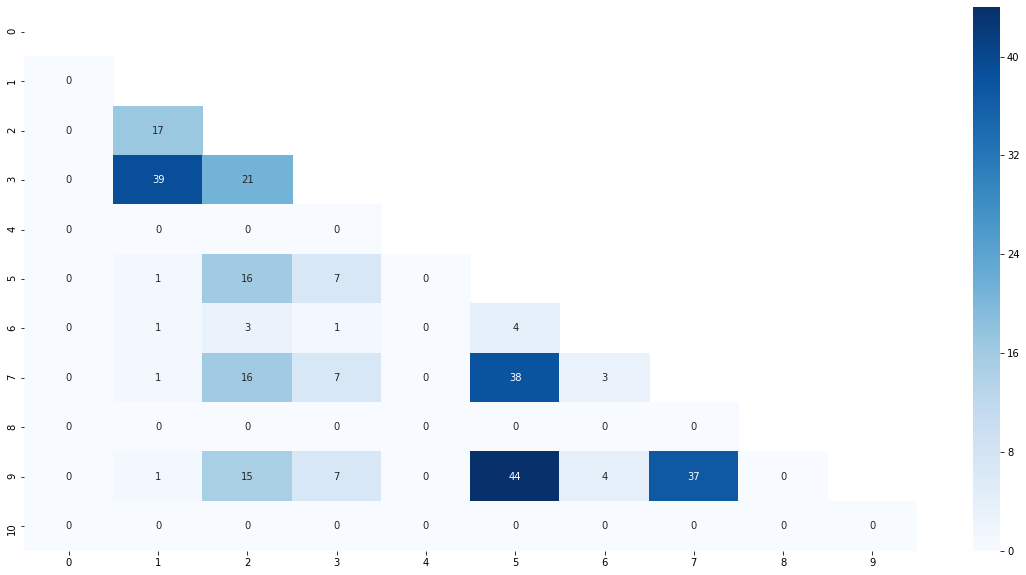

In [19]:
dataplot = get_dict(preprocess_dict=data_dict, 
                    dataplot=get_dataplot(data_dict, model_dict), 
                    threshold=0.9)

mask = np.zeros_like(dataplot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=pd.DataFrame(dataplot), mask=mask, cmap='Blues', annot=True)

In [20]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv(source, sep=";").iloc[[9,5]].transpose().sample(5)

,9,5
Resposta 32,"Os sistemas de tradução automática foram desenvolvidos, mas atualmente os melhores resultados que podem alcançar são inadequados para a maioria dos usos. Uma maneira pela qual eles podem ser usados é em combinação com um tradutor humano. A máquina é capaz de fornecer uma tradução aproximada, e o ser humano então arruma o texto resultante, assegurando que as ambiguidades tenham sido tratadas corretamente e que o texto traduzido pareça natural, além de gramaticalmente correto.","O processo pelo qual um sistema de processamento de linguagem natural determina qual significado é pretendido por um enunciado ambíguo é conhecido como desambiguação. A desambiguação pode ser feita de várias maneiras. Uma das formas mais eficazes de superar muitas formas de ambiguidade é usar probabilidade. Isso pode ser feito usando probabilidades anteriores ou probabilidades condicionais. A probabilidade anterior pode ser usada para dizer ao sistema que a palavra bat quase sempre significa uma peça de equipamento esportivo. Probabilidade condicional diria que quando a palavra bat é usada por um fã de esportes, é provável que este seja o caso, mas que quando é falado por um naturalista é mais provável que seja um mamífero alado."
Resposta 19,As árvores de análise podem ser construídas de baixo para cima ou de cima para baixo. Construir uma árvore de análise de cima para baixo envolve começar de uma sentença e determinar quais das possíveis reescritas para Sentença podem ser aplicadas à sentença que está sendo usada. analisado.,As árvores de análise podem ser construídas de baixo para cima ou de cima para baixo. Construir uma árvore de análise de cima para baixo envolve começar de uma sentença e determinar quais das possíveis reescritas para Sentença podem ser aplicadas à sentença que está sendo usada. analisado.
Resposta 22,"Uma rede de transição aumentada, ou ATN, é uma versão estendida de uma rede de transição. Os ATNs têm a capacidade de aplicar testes a arcos, por exemplo, para garantir o acordo com o número. Assim, um ATN para sentença seria como mostrado na Figura 20.2, mas o arco do nó S2 para S3 seria condicional no número do verbo que é o mesmo que o número para o substantivo. Assim, se a frase substantiva fosse três cães e a frase verbal fosse azul, a ATN não seria capaz de seguir o arco do nó S2 para S3 porque o número da frase nominal (plural) não corresponde ao número do verbo frase (singular). Em idiomas como o francês, verifica o sexo também seria necessário.","Uma rede de transição aumentada, ou ATN, é uma versão estendida de uma rede de transição. Os ATNs têm a capacidade de aplicar testes a arcos, por exemplo, para garantir o acordo com o número. Assim, um ATN para sentença seria como mostrado na Figura 20.2, mas o arco do nó S2 para S3 seria condicional no número do verbo que é o mesmo que o número para o substantivo. Assim, se a frase substantiva fosse três cães e a frase verbal fosse azul, a ATN não seria capaz de seguir o arco do nó S2 para S3 porque o número da frase nominal (plural) não corresponde ao número do verbo frase (singular). Em idiomas como o francês, verifica o sexo também seria necessário."
Resposta 33,"O algoritmo de conhecimento é um método comumente usado para identificação de linguagem que usa n-gramas. Um n-grama é simplesmente uma coleção de n letras, mas existem estatísticas detalhadas que indicam a probabilidade de um determinado conjunto de letras ocorrer em qualquer idioma. Assim, por exemplo, o trigrama, e, o, ent e form provavelmente indicam que um documento está em inglês. Quando o algoritmo de conhecimento é apresentado com texto suficiente (geralmente algumas centenas a mil palavras é suficiente), ele é capaz de identificar a linguagem com um grau surpreendentemente alto de precisão.","Os sistemas de tradução automática foram desenvolvidos, mas atualmente os melhores resultados que podem alcançar são inadequados para a maioria dos usos. Uma maneira pela qual eles podem ser usados ​​é e